In [1]:
# Importemos las librerias
import pandas as pd
import matplotlib.pyplot as plt
import os
from pandas import DataFrame
import numpy as np
import cv2
import shutil
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import seaborn as sns
from joblib import Parallel, delayed

# Preparando el set de datos sin filtro

In [2]:
physical_devices = tf.config.list_physical_devices()
print(physical_devices)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [3]:
os.listdir("../DataSetPatrones")

['.ipynb_checkpoints',
 'COVID',
 'COVID_FB',
 'COVID_FE',
 'COVID_FExtractor',
 'Lung_Opacity',
 'Lung_Opacity_FB',
 'Lung_Opacity_FE',
 'Lung_Opacity_FExtractor',
 'metadata.csv',
 'MetadataNormalizada.csv',
 'MetadataNormalizadaFB.csv',
 'MetadataNormalizadaFE.csv',
 'New_metadata.csv',
 'Normal',
 'Normal_FB',
 'Normal_FE',
 'Normal_FExtractor',
 'Pneumonia',
 'Pneumonia_FB',
 'Pneumonia_FE',
 'Pneumonia_FExtractor',
 'X_Data']

In [8]:
######################################## Restaurar las imagenes a sus valores originales ########################################

# Definir los directorios que contienen los diferentes tipos de imágenes
dirlist = [
    '../DataSetPatrones/COVID',
    '../DataSetPatrones/Lung_Opacity',
    '../DataSetPatrones/Normal',
    '../DataSetPatrones/Pneumonia'
]

# Crear un diccionario que mapea las etiquetas a los índices
label_map = {
    'covid': 0,
    'lung_opacity': 1,
    'normal': 2,
    'pneumonia': 3
}

# Crear dos listas vacías para almacenar los paths de archivo y las etiquetas
filepaths = []
labels = []

# Iterar a través de los directorios y agregar los paths de archivo y las etiquetas a las listas creadas anteriormente
for idx, d in enumerate(dirlist):
    flist = os.listdir(d)
    for f in flist:
        fpath = os.path.join(d, f)
        filepaths.append(fpath)
        labels.append(list(label_map.keys())[idx])

# Crear un dataframe con los paths de archivo y las etiquetas
df = pd.DataFrame({'file_paths': filepaths, 'labels': labels})

# Reorganizar el dataframe a un formato legible y guardarlo en un archivo CSV
df.to_csv('../DataSetPatrones/MetadataNormalizada.csv', index=False)

# Contar el número de imágenes en cada clase de etiqueta y mostrar los resultados
print(df['labels'].value_counts())

# Mostrar las primeras filas del dataframe
df.head()

labels
normal          10192
lung_opacity     6012
covid            3616
pneumonia        1345
Name: count, dtype: int64


,file_paths,labels
0,../DataSetPatrones/COVID\COVID-1.png,covid
1,../DataSetPatrones/COVID\COVID-10.png,covid
2,../DataSetPatrones/COVID\COVID-100.png,covid
3,../DataSetPatrones/COVID\COVID-1000.png,covid
4,../DataSetPatrones/COVID\COVID-1001.png,covid


In [9]:
df = pd.read_csv('../DataSetPatrones/MetadataNormalizada.csv')

print("\n Dataset imagenes crudas \n")
print(df['labels'].value_counts())

####################### Aqui estan las 16k imagenes


 Dataset imagenes crudas 

labels
normal          10192
lung_opacity     6012
covid            3616
pneumonia        1345
Name: count, dtype: int64


In [10]:
# Leer el dataset desde un archivo CSV o cargarlo directamente en un DataFrame
df = pd.read_csv('../DataSetPatrones/MetadataNormalizada.csv')

# Dividir los datos en características (X) y etiquetas (y)
X = df['file_paths']
y = df['labels']

# Codificar las etiquetas como valores numéricos
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

# Preprocesar los datos de las imágenes en paralelo
#n_jobs son la cantidad de nucleos disponibles en su compu 

def preprocess_image_parallel(file_paths):
    return Parallel(n_jobs=10)(delayed(preprocess_image)(file_path) for file_path in file_paths)

# Preprocesar los datos de las imágenes
def preprocess_image(file_path):
    img = cv2.imread(file_path)
    img = cv2.resize(img, (244, 244))  # Redimensionar las imágenes a 244x244
    img = img / 255.0  # Normalizar los valores de píxeles entre 0 y 1
    return img

X_train = np.array(preprocess_image_parallel(X_train))
X_test = np.array(preprocess_image_parallel(X_test))

In [13]:
print(X_train[0].shape)

(244, 244, 3)


# Modelo CNN con una capa de convolución, aplicado al set de datos sin filtro

Epoch 1/10


C:\Users\J. Zaet\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


133/133 [==============================] - 225s 2s/step - loss: 1.4355 - accuracy: 0.6801 - val_loss: 0.5867 - val_accuracy: 0.7678
Epoch 2/10
133/133 [==============================] - 191s 1s/step - loss: 0.4766 - accuracy: 0.8231 - val_loss: 0.5243 - val_accuracy: 0.8023
Epoch 3/10
133/133 [==============================] - 191s 1s/step - loss: 0.3915 - accuracy: 0.8555 - val_loss: 0.4683 - val_accuracy: 0.8285
Epoch 4/10
133/133 [==============================] - 191s 1s/step - loss: 0.3211 - accuracy: 0.8836 - val_loss: 0.4524 - val_accuracy: 0.8337
Epoch 5/10
133/133 [==============================] - 190s 1s/step - loss: 0.2682 - accuracy: 0.9030 - val_loss: 0.4516 - val_accuracy: 0.8394
Epoch 6/10
133/133 [==============================] - 190s 1s/step - loss: 0.2261 - accuracy: 0.9219 - val_loss: 0.4419 - val_accuracy: 0.8410
Epoch 7/10
133/133 [==============================] - 191s 1s/step - loss: 0.1864 - accuracy: 0.9363 - val_loss: 0.4695 - val_accuracy: 0.8332
Epoch 8/10

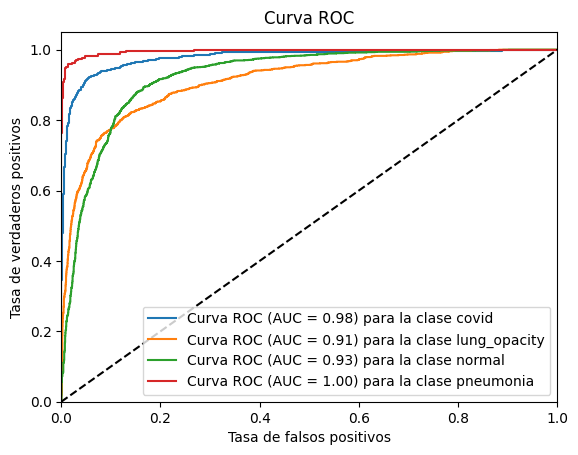

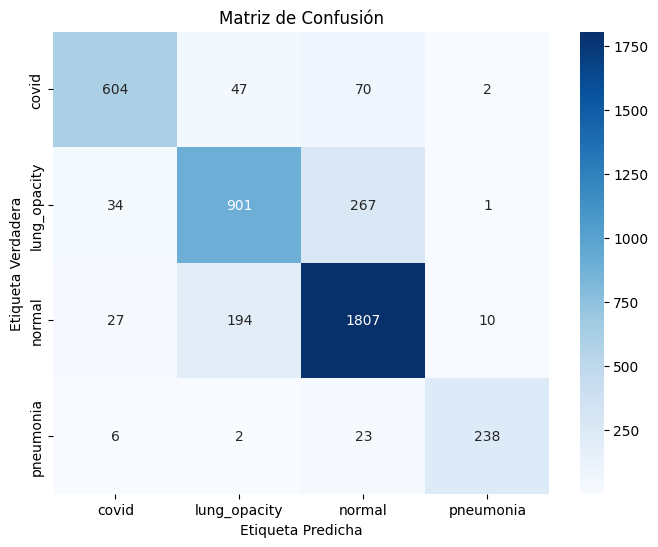

In [14]:
# Crear el modelo de red convolucional
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(244, 244, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(4, activation='softmax'))

# Compilar el modelo
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Entrenar el modelo
model.fit(X_train, y_train, epochs=10, batch_size=128, validation_data=(X_test, y_test))

# Predecir las etiquetas para los datos de prueba
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Calcular las métricas para cada clase
report = classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_)

# Imprimir el informe de clasificación
print(report)

# Obtener las probabilidades de predicción para cada clase
y_pred_proba = model.predict(X_test)

fpr = dict()  # Tasa de falsos positivos
tpr = dict()  # Tasa de verdaderos positivos
roc_auc = dict()  # Área bajo la curva (AUC)

# Calcular la curva ROC y el AUC para cada clase
for i in range(4):  # Suponiendo que tienes 4 clases
    fpr[i], tpr[i], _ = roc_curve(y_test, y_pred_proba[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Graficar la curva ROC
plt.figure()
for i in range(4):  # Suponiendo que tienes 4 clases
    plt.plot(fpr[i], tpr[i], label='Curva ROC (AUC = %0.2f) para la clase %s' % (roc_auc[i], label_encoder.classes_[i]))
plt.plot([0, 1], [0, 1], 'k--')  # Línea diagonal
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_pred_classes)

# Obtener los nombres de las etiquetas originales
etiquetas_originales = label_encoder.inverse_transform(np.unique(y_test))

# Crear un mapa de calor de la matriz de confusión con etiquetas originales
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=etiquetas_originales, yticklabels=etiquetas_originales)
plt.title('Matriz de Confusión')
plt.xlabel('Etiqueta Predicha')
plt.ylabel('Etiqueta Verdadera')
plt.show()


# Visualizando los datos mas influyentes, aplicado al set de datos sin filtro

In [24]:
def visualize_saliency_maps(model, images, N):
    # Obtener el modelo de la última capa convolucional
    last_conv_layer = model.get_layer(index=-3)

    # Crear un nuevo modelo que toma como entrada la imagen original y produce salidas desde la última capa convolucional
    heatmap_model = tf.keras.models.Model([model.inputs], [last_conv_layer.output, model.output])

    for i in range(N):
        # Obtener la imagen de ejemplo para visualizar
        example_image = images[i]

        # Expandir dimensiones de la imagen de ejemplo para que coincida con las dimensiones de entrada del modelo
        example_image = np.expand_dims(example_image, axis=0)

        # Obtener el mapa de activación y las predicciones para la imagen de ejemplo
        heatmap, predictions = heatmap_model.predict(example_image)

        # Obtener el índice de la clase predicha
        predicted_class_index = np.argmax(predictions)

        # Obtener el mapa de activación promediado en el eje de los canales
        heatmap = np.mean(heatmap, axis=-1)

        # Normalizar el mapa de activación en el rango [0, 1]
        heatmap = np.maximum(heatmap, 0) / np.max(heatmap)

        # Redimensionar el mapa de activación para que coincida con las dimensiones de la imagen original
        heatmap = cv2.resize(heatmap, (example_image.shape[2], example_image.shape[1]), interpolation=cv2.INTER_LINEAR)

        # Superponer el mapa de activación en la imagen original
        heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
        superimposed_img = cv2.addWeighted(cv2.cvtColor(np.uint8(255 * example_image[0]), cv2.COLOR_RGB2BGR), 0.6, heatmap, 0.4, 0)

        # Visualizar la imagen original, el mapa de activación y la imagen superpuesta
        fig, ax = plt.subplots(1, 3, figsize=(12, 4))
        ax[0].imshow(example_image[0])
        ax[0].axis('off')
        ax[0].set_title('Imagen Original')
        ax[1].imshow(heatmap)
        ax[1].axis('off')
        ax[1].set_title('Mapa de Activación')
        ax[2].imshow(superimposed_img)
        ax[2].axis('off')
        ax[2].set_title('Imagen Superpuesta')
        plt.show()


1/1 [==============================] - 0s 67ms/step


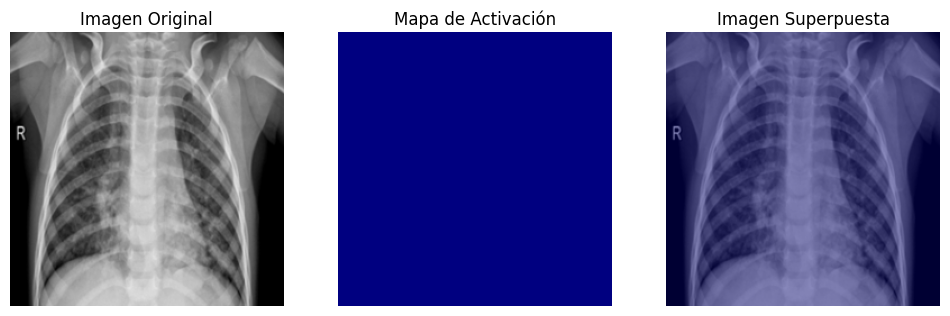

1/1 [==============================] - 0s 30ms/step


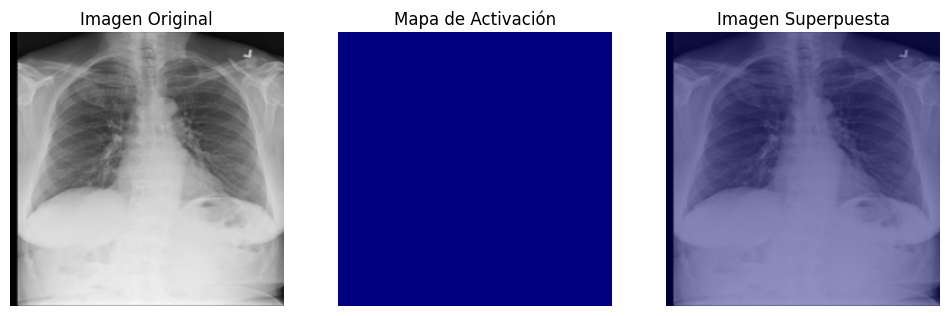

1/1 [==============================] - 0s 30ms/step


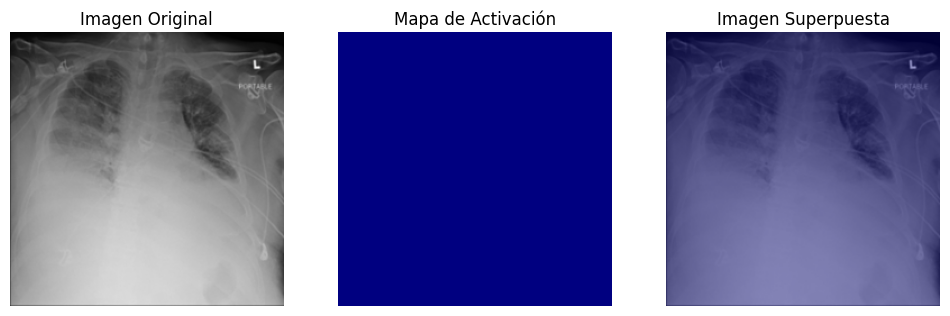

1/1 [==============================] - 0s 34ms/step


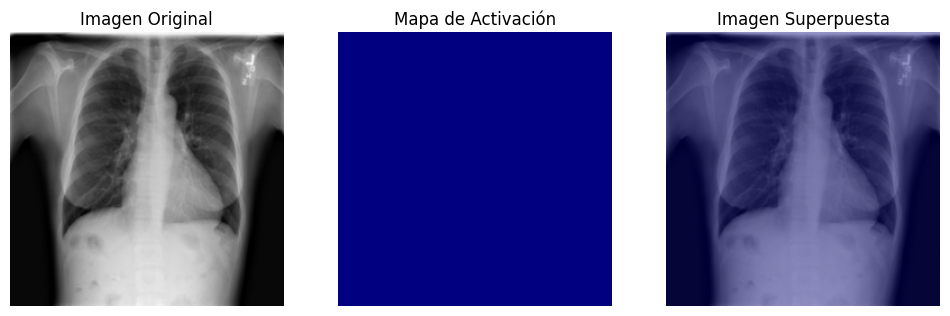

1/1 [==============================] - 0s 30ms/step


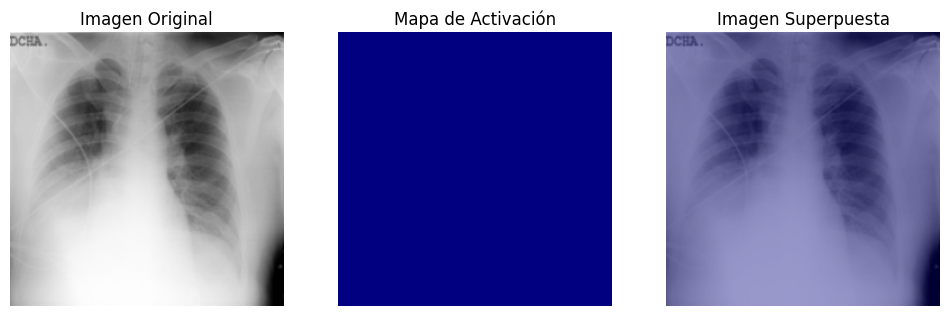

1/1 [==============================] - 0s 34ms/step


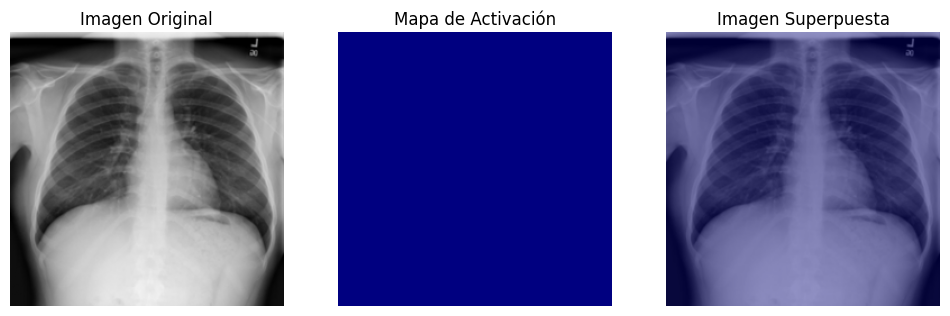

1/1 [==============================] - 0s 30ms/step


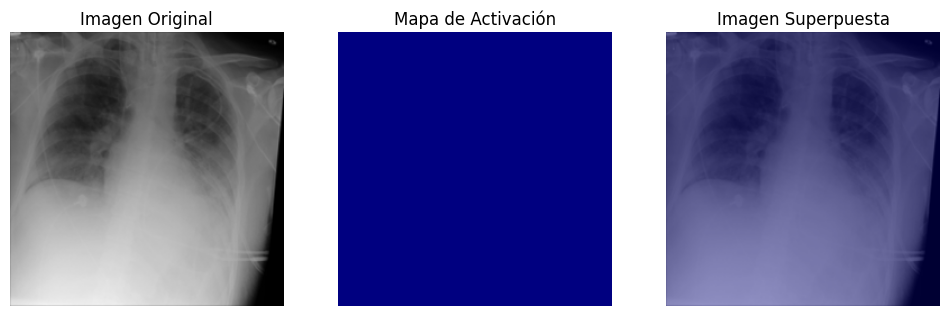

1/1 [==============================] - 0s 34ms/step


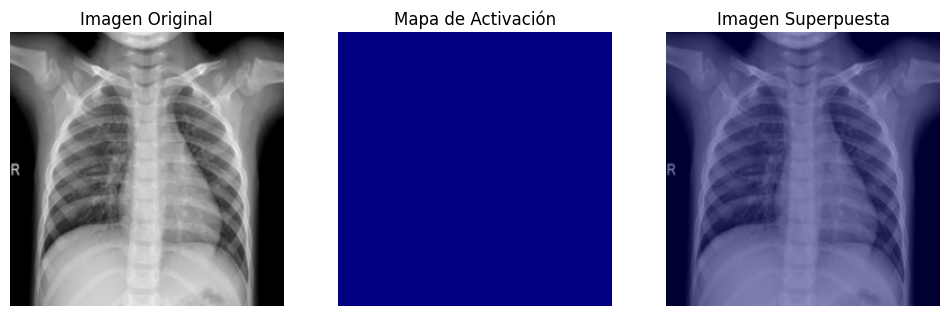

1/1 [==============================] - 0s 33ms/step


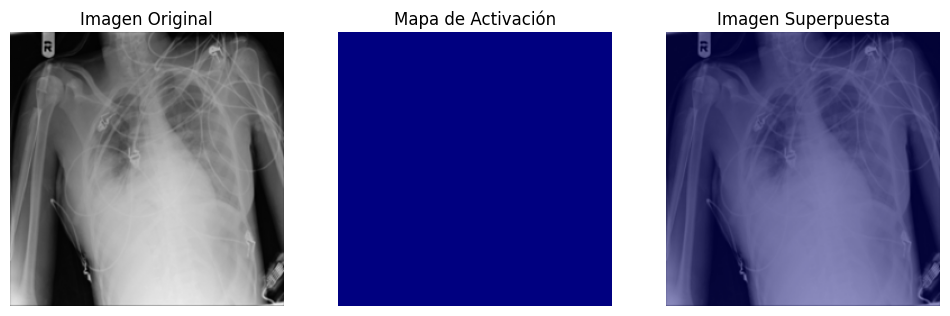

1/1 [==============================] - 0s 31ms/step


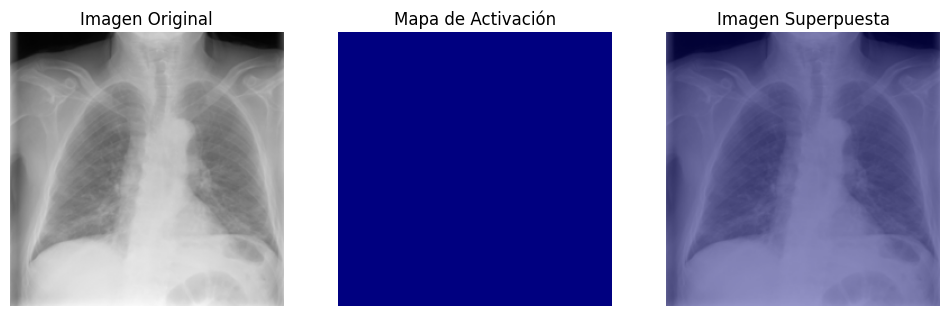

In [25]:
N = 10  # Número de imágenes a visualizar
images_to_visualize = X_test[:N]  # Obtener las primeras N imágenes de X_test

visualize_saliency_maps(model, images_to_visualize, N)

# Preparando el set de datos con el filtro bilateral

In [2]:
######################################## Restaurar las imagenes a sus valores originales ########################################

# Definir los directorios que contienen los diferentes tipos de imágenes
dirlist = [
    '../DataSetPatrones/COVID_FB',
    '../DataSetPatrones/Lung_Opacity_FB',
    '../DataSetPatrones/Normal_FB',
    '../DataSetPatrones/Pneumonia_FB'
]

# Crear un diccionario que mapea las etiquetas a los índices
label_map = {
    'covid': 0,
    'lung_opacity': 1,
    'normal': 2,
    'pneumonia': 3
}

# Crear dos listas vacías para almacenar los paths de archivo y las etiquetas
filepaths = []
labels = []

# Iterar a través de los directorios y agregar los paths de archivo y las etiquetas a las listas creadas anteriormente
for idx, d in enumerate(dirlist):
    flist = os.listdir(d)
    for f in flist:
        fpath = os.path.join(d, f)
        filepaths.append(fpath)
        labels.append(list(label_map.keys())[idx])

# Crear un dataframe con los paths de archivo y las etiquetas
df = pd.DataFrame({'file_paths': filepaths, 'labels': labels})

# Reorganizar el dataframe a un formato legible y guardarlo en un archivo CSV
df.to_csv('../DataSetPatrones/MetadataNormalizadaFB.csv', index=False)

# Contar el número de imágenes en cada clase de etiqueta y mostrar los resultados
print(df['labels'].value_counts())

# Mostrar las primeras filas del dataframe
df.head()

labels
normal          10192
lung_opacity     6012
covid            3616
pneumonia        1345
Name: count, dtype: int64


,file_paths,labels
0,../DataSetPatrones/COVID_FB\COVID-1.png,covid
1,../DataSetPatrones/COVID_FB\COVID-10.png,covid
2,../DataSetPatrones/COVID_FB\COVID-100.png,covid
3,../DataSetPatrones/COVID_FB\COVID-1000.png,covid
4,../DataSetPatrones/COVID_FB\COVID-1001.png,covid


In [4]:
df = pd.read_csv('../DataSetPatrones/MetadataNormalizadaFB.csv')

print("\n Dataset imagenes con filtro bilateral \n")
print(df['labels'].value_counts())

####################### Aqui estan las 16k imagenes


 Dataset imagenes con filtro bilateral 

labels
normal          10192
lung_opacity     6012
covid            3616
pneumonia        1345
Name: count, dtype: int64


In [3]:
# Leer el dataset desde un archivo CSV o cargarlo directamente en un DataFrame
df = pd.read_csv('../DataSetPatrones/MetadataNormalizadaFB.csv')

# Dividir los datos en características (X) y etiquetas (y)
X = df['file_paths']
y = df['labels']

# Codificar las etiquetas como valores numéricos
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

# Preprocesar los datos de las imágenes en paralelo
#n_jobs son la cantidad de nucleos disponibles en su compu 

def preprocess_image_parallel(file_paths):
    return Parallel(n_jobs=10)(delayed(preprocess_image)(file_path) for file_path in file_paths)

# Preprocesar los datos de las imágenes
def preprocess_image(file_path):
    img = cv2.imread(file_path)
    img = cv2.resize(img, (244, 244))  # Redimensionar las imágenes a 244x244
    img = img / 255.0  # Normalizar los valores de píxeles entre 0 y 1
    return img

X_train = np.array(preprocess_image_parallel(X_train))
X_test = np.array(preprocess_image_parallel(X_test))

In [6]:
print(X_train[0].shape)

(244, 244, 3)


# Modelo CNN con una capa de convolución, aplicado al set de datos con filtro bilateral

Epoch 1/10


C:\Users\J. Zaet\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


133/133 [==============================] - 195s 1s/step - loss: 1.8114 - accuracy: 0.6156 - val_loss: 0.6982 - val_accuracy: 0.7309
Epoch 2/10
133/133 [==============================] - 163s 1s/step - loss: 0.5777 - accuracy: 0.7749 - val_loss: 0.5686 - val_accuracy: 0.7860
Epoch 3/10
133/133 [==============================] - 157s 1s/step - loss: 0.4805 - accuracy: 0.8162 - val_loss: 0.5750 - val_accuracy: 0.7914
Epoch 4/10
133/133 [==============================] - 156s 1s/step - loss: 0.4017 - accuracy: 0.8511 - val_loss: 0.5226 - val_accuracy: 0.8060
Epoch 5/10
133/133 [==============================] - 157s 1s/step - loss: 0.3525 - accuracy: 0.8704 - val_loss: 0.4831 - val_accuracy: 0.8235
Epoch 6/10
133/133 [==============================] - 158s 1s/step - loss: 0.3159 - accuracy: 0.8852 - val_loss: 0.5220 - val_accuracy: 0.8042
Epoch 7/10
133/133 [==============================] - 157s 1s/step - loss: 0.2713 - accuracy: 0.9004 - val_loss: 0.4887 - val_accuracy: 0.8297
Epoch 8/10

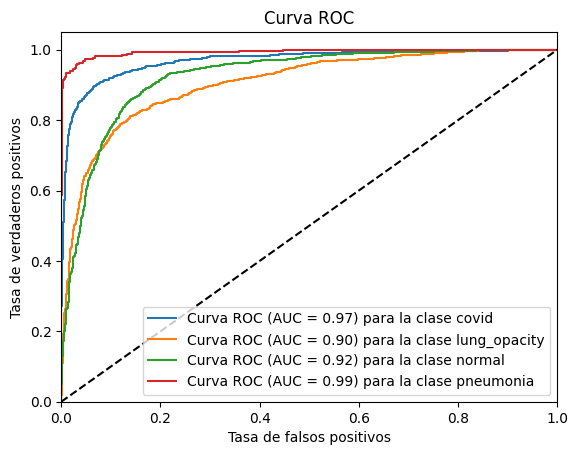

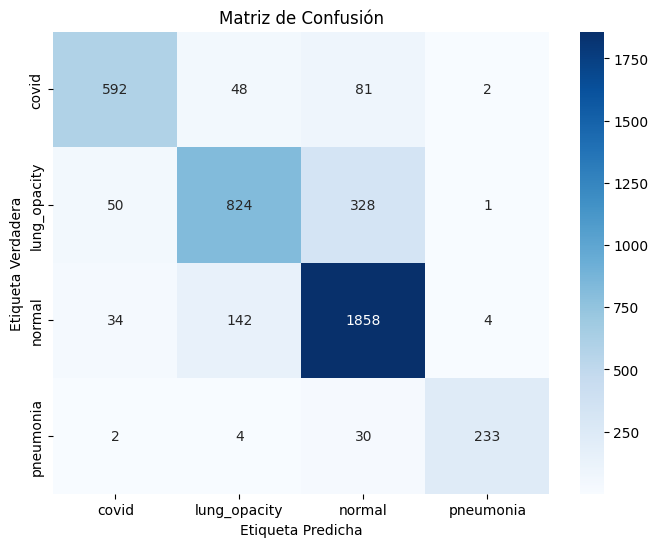

In [4]:
# Crear el modelo de red convolucional
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(244, 244, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(4, activation='softmax'))

# Compilar el modelo
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Entrenar el modelo
model.fit(X_train, y_train, epochs=10, batch_size=128, validation_data=(X_test, y_test))

# Predecir las etiquetas para los datos de prueba
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Calcular las métricas para cada clase
report = classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_)

# Imprimir el informe de clasificación
print(report)

# Obtener las probabilidades de predicción para cada clase
y_pred_proba = model.predict(X_test)

fpr = dict()  # Tasa de falsos positivos
tpr = dict()  # Tasa de verdaderos positivos
roc_auc = dict()  # Área bajo la curva (AUC)

# Calcular la curva ROC y el AUC para cada clase
for i in range(4):  # Suponiendo que tienes 4 clases
    fpr[i], tpr[i], _ = roc_curve(y_test, y_pred_proba[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Graficar la curva ROC
plt.figure()
for i in range(4):  # Suponiendo que tienes 4 clases
    plt.plot(fpr[i], tpr[i], label='Curva ROC (AUC = %0.2f) para la clase %s' % (roc_auc[i], label_encoder.classes_[i]))
plt.plot([0, 1], [0, 1], 'k--')  # Línea diagonal
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_pred_classes)

# Obtener los nombres de las etiquetas originales
etiquetas_originales = label_encoder.inverse_transform(np.unique(y_test))

# Crear un mapa de calor de la matriz de confusión con etiquetas originales
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=etiquetas_originales, yticklabels=etiquetas_originales)
plt.title('Matriz de Confusión')
plt.xlabel('Etiqueta Predicha')
plt.ylabel('Etiqueta Verdadera')
plt.show()


# Visualizando los datos mas influyentes, aplicado al set de datos con filtro bilateral